In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']


In [5]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1512560, 25)
(709325, 22)


In [67]:
pp = Preprocess(df_transaction, df_property, target='sqft_price')

In [68]:
use_features = pp.get_feature_list()

In [77]:
# records of last year
#use_features = ['sqft', 'num_bed', 'num_bath', 'view', 'pool', 'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 'impr_over_land']
#df_track = pp.dataset(feature_set=use_features, valid=True, date=('2015-10-01', '2017-10-01'))
df_track = pp.dataset(feature='delivered', valid=True, date=('2015-10-01', '2017-10-01'))
monthly_volume = int(df_track.shape[0] / 24)
print(df_track.shape)
df_track.head()

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon


(68908, 15)


,sqft,lon,sqft_price,pool,impr_over_land,zip,num_bath,sqft_zip_avg,num_bed,date,lat,id,view,sqft_price_zip_avg,sold_price_zip_avg
0,1064,-117.10164,325,0,1.015708,92131,2.0,2162.542982,2.0,2015-10-01,32.93745,1428580,0,334.725439,698046.052632
18277,3172,-117.15680,242,1,2.009366,92069,3.0,1851.554437,5.0,2015-10-01,33.16329,1428680,1,259.656908,460152.790485
19369,1108,-117.15701,544,0,1.680000,92101,2.0,1069.848516,2.0,2015-10-01,32.72103,1428594,1,524.557318,576143.807574
21323,1991,-116.96510,210,0,1.791746,91978,3.0,1698.890244,3.0,2015-10-01,32.73226,1428595,0,235.934959,379536.585366
21324,1530,-116.95756,1,0,2.501813,91978,2.0,1698.890244,4.0,2015-10-01,32.72749,1428640,0,235.934959,379536.585366


## Random Forest Model

10-fold cross-validation to select the best number of trees and depth of each tree in the forest.

In [72]:
### segment on sold_price
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
mm = ModelManager(df_track, use_features, rf, target='sqft_price', time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 57424, 34452, 11484
[dp] train/valid/test size: 45939, 11485, 11484
[dp] validation step is skipped


72.55290327804384

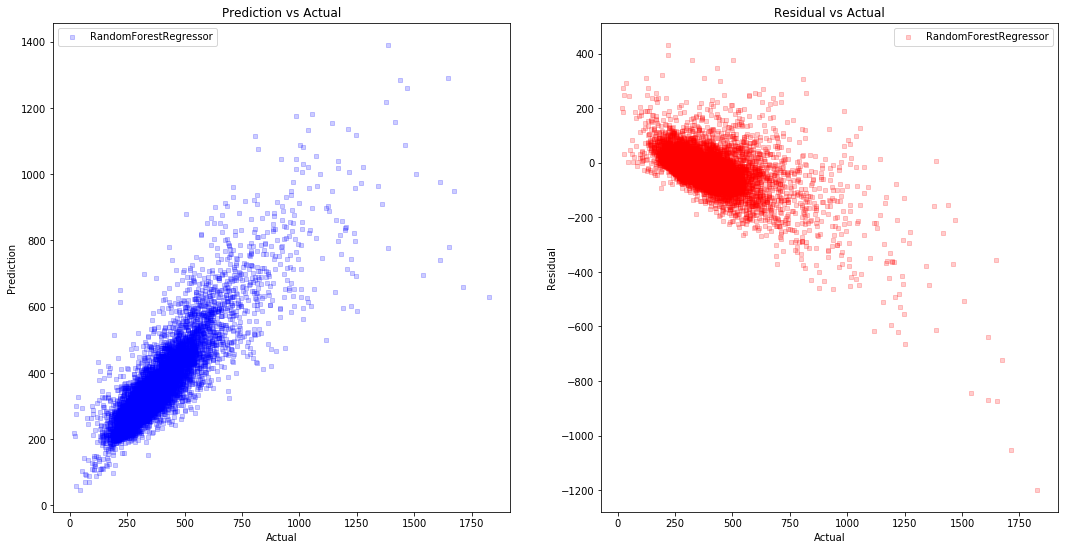

In [73]:
mm.plot_residual()

In [78]:
#df_check = mm.get_result_df(pp)
df_check = pp.debug(mm.get_result_df())

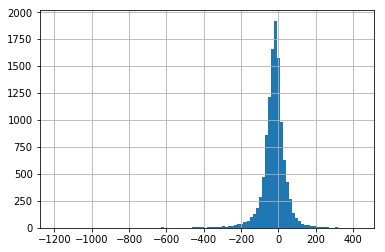

In [49]:
df_check['residual'].hist(bins=100)

In [80]:
def remeasure(df_check):
    df_check['predict_sold_price'] = df_check['predict'] * df_check['sqft']
    df_check['sold_price'] = df_check['sqft_price'] * df_check['sqft']
    return sqrt(mean_squared_error(df_check['predict_sold_price'], df_check['sold_price']))

In [81]:
remeasure(df_check)

125352.41763190337